In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint


2024-01-22 14:56:05.400648: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 14:56:05.933116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 14:56:05.933185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 14:56:06.046110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 14:56:06.282088: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 14:56:06.283984: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, num_classes):
    
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # Contraction Path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansion Path
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    concat6 = concatenate([up6, drop4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 
    #model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=num_classes, name='mean_iou')])
    return model

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    #plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap="gray")
    plt.imshow(display_list[i], cmap="gray")
    plt.axis('on')
  plt.show()

In [3]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 256
IMG_HEIGHT = 128
IMG_CHANNELS = 1

ROOT = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/masks'
IMAGE_PATH = os.path.join(ROOT, 'tg', 'thumbnail_aligned')
MASK_PATH  = os.path.join(ROOT, 'tg', 'thumbnail_masked')
files = sorted(os.listdir(IMAGE_PATH))
files = files[0:100]

X = np.zeros((len(files), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
y = np.zeros((len(files), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

print('Resizing training images and masks')
for n, file in enumerate(tqdm(files)):
    filepath = os.path.join(IMAGE_PATH, file)
    maskpath = os.path.join(MASK_PATH, file)
    img = imread(filepath)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = imread(maskpath)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    y[n] = mask 


Resizing training images and masks


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
model = unet_model(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS, num_classes=1)

In [8]:
callbacks = [
        ModelCheckpoint("model-unet.keras",verbose=1,save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=2, callbacks=callbacks)

Epoch 1/2
5/5 [==============================] - ETA: 0s - loss: -0.5131 - accuracy: 0.6430
Epoch 1: val_loss improved from inf to -1.90342, saving model to model-unet.h5


/usr/local/share/pipeline/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 36s 7s/step - loss: -0.5131 - accuracy: 0.6430 - val_loss: -1.9034 - val_accuracy: 0.6415
Epoch 2/2
5/5 [==============================] - ETA: 0s - loss: -2.4363 - accuracy: 0.6959
Epoch 2: val_loss improved from -1.90342 to -3.00428, saving model to model-unet.h5
5/5 [==============================] - 33s 7s/step - loss: -2.4363 - accuracy: 0.6959 - val_loss: -3.0043 - val_accuracy: 0.6520


In [11]:
model.save('unet.keras')

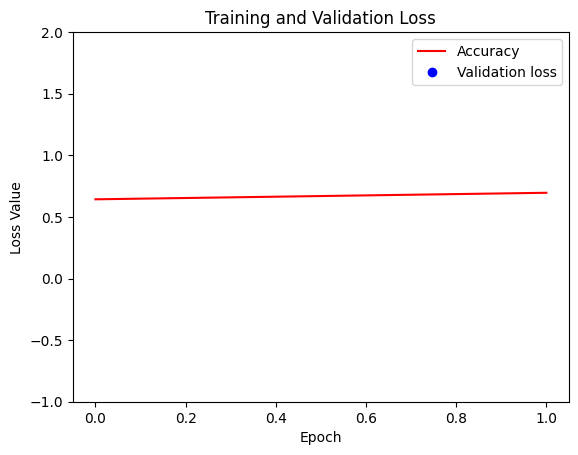

In [10]:
#loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
accuracy = model.history.history['accuracy']
plt.figure()
plt.plot( accuracy, 'r', label='Accuracy')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([-1, 2])
plt.legend()
plt.show()

In [ ]:
i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.9995).astype(np.uint8)
display([sample_image, sample_mask, predicted_mask])